In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from itertools import cycle
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
from libs.metrics import calculate_metrics, metrics_to_table, metrics_to_latex
from libs.pre_processing import generate_groups_data_flat, generate_groups_data_matrix
from libs.visual_analysis import visualize_fit, visualize_predict, traceplot, visualize_prior, model_graph
from libs.model import HGPforecaster, PiecewiseLinearChangepoints

import theano
theano.config.compute_test_value='raise'

In [2]:
# Read in the data
INPUT_DIR = '../benchmark/m5-data'
cal = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
stv = pd.read_csv(f'{INPUT_DIR}/sales_train_validation.csv')
ss = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')
sellp = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')

We are given historic sales data in the `sales_train_validation` dataset.
- rows exist in this dataset for days d_1 to d_1913. We are given the department, category, state, and store id of the item.
- d_1914 - d_1941 represents the `validation` rows which we will predict in stage 1
- d_1942 - d_1969 represents the `evaluation` rows which we will predict for the final competition standings.

In [3]:
d_cols = [c for c in stv.columns if 'd_' in c] # sales data columns

In [4]:
print(f'Number of unique items: {np.unique(stv.item_id).shape[0]}')
print(f'Number of unique department: {np.unique(stv.dept_id).shape[0]}')
print(f'Number of unique categories: {np.unique(stv.cat_id).shape[0]}')
print(f'Number of unique stores: {np.unique(stv.store_id).shape[0]}')
print(f'Number of unique states: {np.unique(stv.state_id).shape[0]}')

Number of unique items: 3049
Number of unique department: 7
Number of unique categories: 3
Number of unique stores: 10
Number of unique states: 3


In [5]:
# Transform column wide days to single column 

stv = stv.melt(list(stv.columns[:6]), var_name='day', value_vars=list(stv.columns[6:]), ignore_index=True)

In [6]:
# Group by the groups to consider (remove product_id as there are 3049 unique) 

stv = stv.groupby(['dept_id', 'cat_id', 'store_id', 'state_id', 'day']).sum('value').reset_index()

In [7]:
days_calendar = np.concatenate((stv['day'].unique().reshape(-1,1), cal['date'][:-56].unique().reshape(-1,1)), axis=1)
df_caldays = pd.DataFrame(days_calendar, columns = ['day','Date'])

In [8]:
# Add calendar days

stv = stv.merge(df_caldays, how='left', on='day')

In [9]:
stv['Date'] = stv['Date'].astype('datetime64[ns]')

In [10]:
# Transform in weekly data

#stv_weekly = stv.groupby(['dept_id', 'cat_id', 'store_id', 'state_id']).resample('W', on='Date')['value'].sum()

<AxesSubplot:xlabel='Date'>

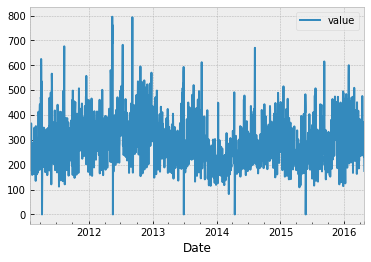

In [11]:
stv.loc[(stv.dept_id=='FOODS_1')&(stv.cat_id=='FOODS')&(stv.store_id=='CA_1')&(stv.state_id=='CA')][['Date', 'value']].set_index('Date').plot()

In [12]:
stv_fd = stv.loc[stv.Date > '2015-04-01']

In [13]:
# Build the structure to then apply the grouping transformation

stv_pivot = stv_fd.reset_index().pivot(index='Date',columns=['dept_id', 'cat_id', 'store_id', 'state_id'], values='value')
stv_pivot = stv_pivot.fillna(0)

In [14]:
stv_pivot

dept_id    FOODS_1                                              FOODS_2       \
cat_id       FOODS                                                FOODS        
store_id      CA_1 CA_2 CA_3 CA_4 TX_1 TX_2 TX_3 WI_1 WI_2 WI_3    CA_1 CA_2   
state_id        CA   CA   CA   CA   TX   TX   TX   WI   WI   WI      CA   CA   
Date                                                                           
2015-04-02     211  328  307  143  213  263  157  168  234  206     550  100   
2015-04-03     225  323  373  145  128  189  104  255  154  190     569  168   
2015-04-04     189  327  323  116  161  284  250  227  281  337     545  131   
2015-04-05     276  377  328  149  234  313  178  255  374  350     631  123   
2015-04-06     338  528  529  174  220  385  218  282  320  341     749  193   
...            ...  ...  ...  ...  ...  ...  ...  ...  ...  ...     ...  ...   
2016-04-20     370  468  347  200  206  275  261  348  259  249     448  141   
2016-04-21     291  526  428  180  200  244  263  279  226  181     549  164   
2016-04-22     231  345  297  190  216  207  158  212  212  145     383   92   
2016-04-23     247  299  285  192  143  224  207  243  182  180     322   84   
2016-04-24     175  291  273  187  148  225  184  198  276  152     277   57   

dept_id                                             FOODS_3                    \
cat_id                                                FOODS                     
store_id   CA_3 CA_4 TX_1 TX_2 TX_3 WI_1  WI_2 WI_3    CA_1  CA_2  CA_3  CA_4   
state_id     CA   CA   TX   TX   TX   WI    WI   WI      CA    CA    CA    CA   
Date                                                                            
2015-04-02  736  303  357  479  508  314   642  419    1724   783  2574   881   
2015-04-03  854  318  489  655  541   66   197  728    2342  1540  2936   934   
2015-04-04  683  328  329  347  347  364  1128  562    1662  1011  2493   887   
2015-04-05  870  249  313  484  412  465   929  609    2104  1195  2727   973   
2015-04-06  979  326  341  513  336  603   765  604    2635  1527  3592  1088   
...         ...  ...  ...  ...  ...  ...   ...  ...     ...   ...   ...   ...   
2016-04-20  613  223  350  469  355  336   535  216    2858  1828  3616  1337   
2016-04-21  672  285  381  471  325  339   430  322    3175  1637  4045  1375   
2016-04-22  560  274  306  390  364  273   359  233    2006  1096  3025  1280   
2016-04-23  441  240  230  341  266  232   387  214    1790  1074  2584  1093   
2016-04-24  483  201  218  361  244  274   417  209    1822  1018  2643   937   

dept_id           ... HOBBIES_2                     HOUSEHOLD_1             \
cat_id            ...   HOBBIES                       HOUSEHOLD              
store_id    TX_1  ...      TX_2 TX_3 WI_1 WI_2 WI_3        CA_1 CA_2  CA_3   
state_id      TX  ...        TX   TX   WI   WI   WI          CA   CA    CA   
Date              ...                                                        
2015-04-02  1274  ...        29   32   25   18   12         397  424   984   
2015-04-03  1455  ...        21   35   19   17   23         463  570   687   
2015-04-04  1226  ...        34   34   22   15   24         341  426   947   
2015-04-05  1546  ...        43   43   16   18   21         414  583   992   
2015-04-06  1607  ...        48   32   25   13   27         673  857  1327   
...          ...  ...       ...  ...  ...  ...  ...         ...  ...   ...   
2016-04-20  1752  ...        50   29   57   28   36         763  943  1678   
2016-04-21  1903  ...        73   39   17   19   20         955  952  1657   
2016-04-22  1393  ...        59   27   31   29   25         655  493  1348   
2016-04-23  1175  ...        49   47   47   27   21         495  460  1232   
2016-04-24  1265  ...        60   40   45   36   21         473  517  1104   

dept_id                                       HOUSEHOLD_2                      \
cat_id                                          HOUSEHOLD                       
store_id   

<AxesSubplot:xlabel='Date'>

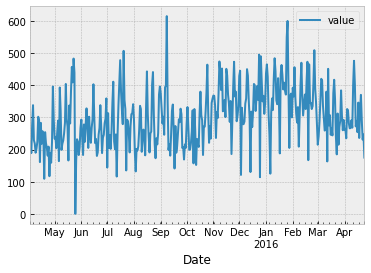

In [15]:
stv_fd.loc[(stv_fd.dept_id=='FOODS_1')&(stv_fd.cat_id=='FOODS')&(stv_fd.store_id=='CA_1')&(stv_fd.state_id=='CA')][['Date', 'value']].set_index('Date').plot()

In [16]:
groups_input = {
    'Department': [0],
    'Category': [1],
    'Store': [2],
    'State': [3]
}

In [17]:
# The dataset results from the removal of item_id (groupby by the ohter groups) and by downsampling to weekly data (the dataset was daily)

groups = generate_groups_data_flat(stv_pivot, groups_input, seasonality=7, h=30)

Number of groups: 4
	Department: 7
	Category: 3
	Store: 10
	State: 3
Total number of series: 70
Number of points per series for train: 359
Total number of points: 389
Seasonality: 7
Forecast horizon: 30


In [18]:
groups['predict']['data'] = groups['predict']['data'].reshape(groups['predict']['s'], groups['predict']['n']).T

In [57]:
df = pd.read_csv('/home/mach1ne/hierarchical_ts_forecaster/benchmark/forecasts_r_m5-daily.csv', index_col=False, sep = ";")

In [58]:
total_df = df

In [59]:
import matplotlib.pyplot as plt
import numpy as np

In [60]:
n = len(np.unique(stv_pivot.index))

In [61]:
#df['date'] = np.tile(np.unique(stv_pivot.index)[n-12:n], int(df.shape[0]/12))

In [62]:
total_df['.mean'] = total_df['.mean'].str.replace(',','.')

In [66]:
total_df.YMD = pd.to_datetime(total_df.YMD)

In [67]:
total_df = total_df.astype({'.mean': 'float32'})

In [68]:
total_df

,Category,State,Department,Store,.model,YMD,Count,.mean
0,FOODS,CA,FOODS_1,CA_1,base,2016-03-26,"N(298, 7141)",297.915192
1,FOODS,CA,FOODS_1,CA_1,base,2016-03-27,"N(298, 7199)",297.915192
2,FOODS,CA,FOODS_1,CA_1,base,2016-03-28,"N(298, 7257)",297.915192
3,FOODS,CA,FOODS_1,CA_1,base,2016-03-29,"N(298, 7315)",297.915192
4,FOODS,CA,FOODS_1,CA_1,base,2016-03-30,"N(298, 7373)",297.915192
...,...,...,...,...,...,...,...,...
13855,<aggregated>,<aggregated>,<aggregated>,<aggregated>,MinT,2016-04-20,"N(35519, 9.7e+07)",35518.875000
13856,<aggregated>,<aggregated>,<aggregated>,<aggregated>,MinT,2016-04-21,"N(35513, 9.9e+07)",35512.847656
13857,<aggregated>,<aggregated>,<aggregated>,<aggregated>,MinT,2016-04-22,"N(35508, 1e+08)",35508.074219
13858,<aggregated>,<aggregated>,<aggregated>,<aggregated>,MinT,2016-04-23,"N(35504, 1e+08)",35504.492188


In [69]:
total_df_mint = total_df[(total_df['.model']=='MinT')&(total_df['Category']!='<aggregated>')&(total_df['State']!='<aggregated>')&(total_df['Department']!='<aggregated>')&(total_df['Store']!='<aggregated>')]

In [71]:
res_mint = total_df_mint.pivot(index='YMD',columns=['Department', 'Category', 'Store', 'State'], values='.mean')

In [72]:
res_mint = res_mint.sort_index(axis=1,level=[0,1, 2, 3],ascending=[True,True, True, True])

In [73]:
res_mint

Department     FOODS_1                                                  \
Category         FOODS                                                   
Store             CA_1        CA_2        CA_3        CA_4        TX_1   
State               CA          CA          CA          CA          TX   
YMD                                                                      
2016-03-26  331.028809  476.600739  374.631531  203.775391  205.242065   
2016-03-27  330.451691  476.208527  374.328217  203.510620  205.061768   
2016-03-28  329.910522  475.846954  374.038818  203.267502  204.900009   
2016-03-29  329.403564  475.514832  373.763184  203.044678  204.755646   
2016-03-30  328.929230  475.210968  373.501099  202.840836  204.627594   
2016-03-31  328.486023  474.934235  373.252350  202.654800  204.514862   
2016-04-01  328.072449  474.683594  373.016724  202.485428  204.416504   
2016-04-02  327.687134  474.457977  372.793915  202.331711  204.331635   
2016-04-03  327.328766  474.256378  372.583679  202.192673  204.259445   
2016-04-04  326.996094  474.077820  372.385712  202.067383  204.199158   
2016-04-05  326.687897  473.921417  372.199707  201.955032  204.150070   
2016-04-06  326.403076  473.786224  372.025391  201.854813  204.111511   
2016-04-07  326.140533  473.671387  371.862457  201.765976  204.082840   
2016-04-08  325.899261  473.576111  371.710571  201.687866  204.063477   
2016-04-09  325.678253  473.499542  371.569458  201.619827  204.052887   
2016-04-10  325.476562  473.440948  371.438751  201.561264  204.050537   
2016-04-11  325.293335  473.399597  371.318176  201.511612  204.055954   
2016-04-12  325.127747  473.374786  371.207428  201.470337  204.068680   
2016-04-13  324.978912  473.365784  371.106171  201.436966  204.088287   
2016-04-14  324.846161  473.371979  371.014130  201.411041  204.114410   
2016-04-15  324.728668  473.392761  370.930969  201.392105  204.146637   
2016-04-16  324.625793  473.427490  370.856445  201.379776  204.184647   
2016-04-17  324.536865  473.475586  370.790222  201.373688  204.228104   
2016-04-18  324.461243  473.536499  370.732025  201.373459  204.276703   
2016-04-19  324.398346  473.609711  370.681580  201.378769  204.330139   
2016-04-20  324.347534  473.694702  370.638611  201.389313  204.388153   
2016-04-21  324.308319  473.790985  370.602844  201.404800  204.450500   
2016-04-22  324.280182  473.898071  370.574066  201.424942  204.516937   
2016-04-23  324.262573  474.015503  370.551971  201.449493  204.587219   
2016-04-24  324.255066  474.142883  370.536346  201.478210  204.661148   

Department                                                              \
Category                                                                 
Store             TX_2        TX_3        WI_1        WI_2        WI_3   
State               TX          TX          WI          WI          WI   
YMD                                                                      
2016-03-26  261.678772  204.979141  270.705414  262.007690  170.049866   
2016-03-27  260.858002  204.713028  269.810760  261.072754  169.571823   
2016-03-28  260.088470  204.465164  268.968750  260.197815  169.127151   
2016-03-29  259.367340  204.234680  268.176575  259.378967  168.713837   
2016-03-30  258.691956  204.020721  267.431488  258.612579  168.330078   
2016-03-31  258.059845  203.822479  266.730927  257.895264  167.974136   
2016-04-01  257.468628  203.639175  266.072479  257.223785  167.644379   
2016-04-02  256.916138  203.470093  265.453918  256.595306  167.339325   
2016-04-03  256.400269  203.314545  264.873077  256.007019  167.057526   
2016-04-04  255.919067  203.171890  264.328003  255.456390  166.797653   
2016-04-05  255.470703  203.041473  263.816742  254.941055  166.558487   
2016-04-06  255.053436  202.922745  263.337524  254.458801  166.338837   
2016-04-07  254.665619  202.815109  262.888702  254.007568  166.137619   
2016-04-08  254.305725  202.718063  262.468689  253.585434  165.953796   
201

In [74]:
res_mint = res_mint.values

In [75]:
s = groups['train']['s']
h = groups['h']

In [76]:
res = np.tile(res_mint.T.reshape(s,h,1), 10)

In [77]:
res = res.transpose(0, 2, 1)

In [78]:
res = np.concatenate((np.zeros((s, 10, n-h), dtype=np.float64), res), axis=2)
res = np.transpose(res, (1, 2, 0))

In [79]:
res.shape

(10, 389, 70)

In [80]:
groups = generate_groups_data_flat(y = stv_pivot, 
                               groups_input = groups_input, 
                               seasonality=7, 
                               h=30)
groups = generate_groups_data_matrix(groups)

Number of groups: 4
	Department: 7
	Category: 3
	Store: 10
	State: 3
Total number of series: 70
Number of points per series for train: 359
Total number of points: 389
Seasonality: 7
Forecast horizon: 30


In [81]:
from sklearn.metrics import mean_squared_error

results = calculate_metrics(res, groups)
metrics_to_table(results)

,bottom,total,Department,Category,Store,State,all
mase,0.819,0.848,0.845,0.824,0.885,0.884,0.821
rmse,127.134,6381.826,1008.351,2219.095,742.941,2290.578,544.114


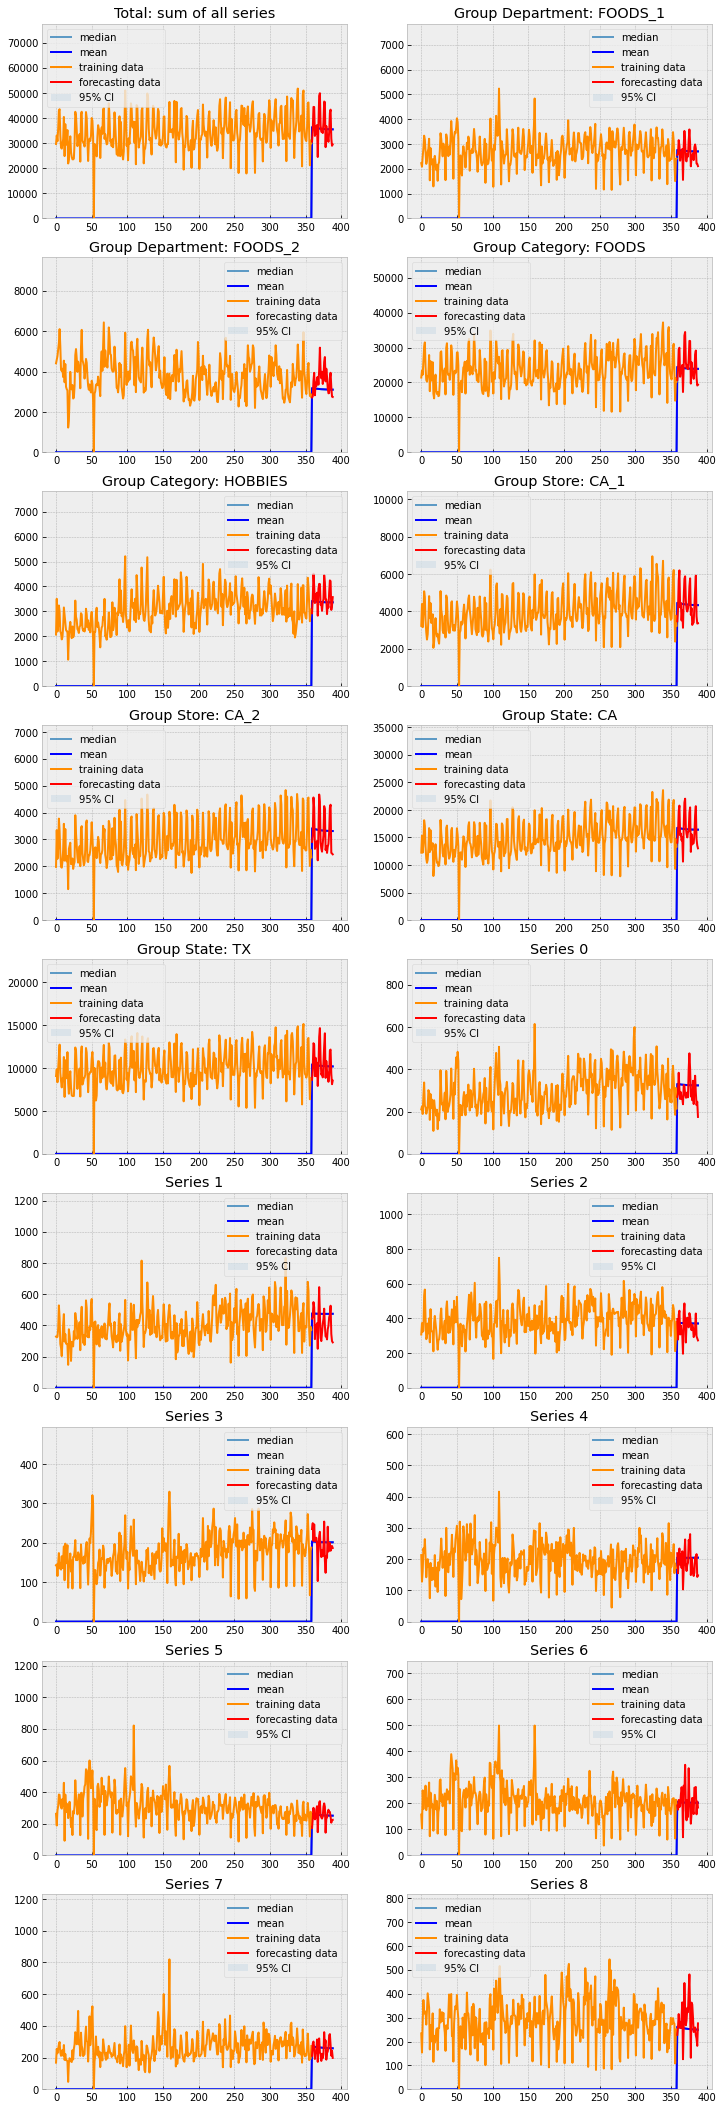

In [82]:
visualize_predict(groups, res, 10)

### Base and bottom-up forecasting

##### Base

In [85]:
def mase(n,seas,h,y,f):
    return np.mean(((n-seas)/h
            * (np.sum(np.abs(y[n:n+h,:] - f), axis=0)
               / np.sum(np.abs(y[seas:n, :] - y[:n-seas, :]), axis=0))))


In [86]:
total_df_mint = total_df[(total_df['.model']=='base')]
res_mint = total_df_mint.pivot(index='YMD',columns=['Department', 'Category', 'Store', 'State'], values='.mean')
res_mint = res_mint.sort_index(axis=1,level=[0,1, 2, 3],ascending=[True,True, True, True])

In [87]:
filters = []
filters.append(['<aggregated>', '<aggregated>', '<aggregated>', '<aggregated>'])
for i in list(groups['train']['groups_names'].keys()):
    for j in groups['train']['groups_names'][i]:
        list_init = ['<aggregated>', '<aggregated>', '<aggregated>', '<aggregated>']
        list_init[list(groups['train']['groups_names'].keys()).index(i)] = j
        filters.append(list_init)

In [88]:
df = pd.DataFrame(columns=['Department', 'Category', 'Store', 'State','.model', 'Count', '.mean', 'YearWeek', 'date'])
for i in filters:
    df = df.append(total_df[(total_df['.model']=='base')&(total_df['Department']==i[0])&((total_df['Category']==i[1])|(total_df['Category']==i[0][:-2]))&(total_df['Store']==i[2])&((total_df['State']==i[3])|(total_df['State']==i[2][:-2]))])

In [89]:
df = df.reset_index().drop('index', axis=1)

In [90]:
h = groups['h']
seasonality = groups['seasonality']

In [91]:
idx_dict_new = {}
s = groups['predict']['s']
n = groups['predict']['n']
y_f = groups['predict']['data'].reshape(s, n).T
mase_ = {}
groups_hier = {'Category': 'Department', 'State': 'Store'}

for group in list(groups['predict']['groups_names'].keys()):
    y_g = np.zeros((groups['predict']['n'], groups['predict']['groups_names'][group].shape[0]))
    f_g = np.zeros((h, groups['predict']['groups_names'][group].shape[0]))

    for idx, name in enumerate(groups['predict']['groups_names'][group]):  
        g_n = groups['predict']['groups_n'][group]

        idx_dict_new[name] = np.where(groups['predict']['groups_idx'][group]==idx,1,0)
        y_g[:,idx] = np.sum(idx_dict_new[name]*y_f, axis=1)
        if group.capitalize()=='Category' or group.capitalize()=='State':
            # if it is one of the top level hierarchies, all the others must be <aggregate>
            f_g[:,idx] = np.squeeze(df[(df[group.capitalize()]==name)&(df[groups_hier[group.capitalize()]]=='<aggregated>')][['.mean']].values)
        else:
            f_g[:,idx] = np.squeeze(df[(df[group.capitalize()]==name)][['.mean']].values)

    mase_[group] = np.round(mase(n=n-h, 
         seas=seasonality, 
         h=h, 
         y=y_g, 
         f=f_g)
    ,3)

In [92]:
mase_

{'Department': 0.914, 'Category': 0.889, 'Store': 0.928, 'State': 0.927}

In [93]:
total_df_mint = total_df[(total_df['.model']=='base')&(total_df['Category']=='<aggregated>')&(total_df['State']=='<aggregated>')&(total_df['Department']=='<aggregated>')&(total_df['Store']=='<aggregated>')]
res_mint = total_df_mint.pivot(index='YMD',columns=['Department', 'Category', 'Store', 'State'], values='.mean')
res_mint = res_mint.sort_index(axis=1,level=[0,1, 2, 3],ascending=[True,True, True, True])
res_mint = res_mint.values
f_g = res_mint

In [94]:
y_g = np.sum(groups['predict']['data'].reshape(groups['predict']['s'], groups['predict']['n']).T, axis=1)

In [95]:
mase_total = np.round(mase(n=n-h, 
         seas=seasonality, 
         h=h, 
         y=y_g.reshape(-1,1), 
         f=f_g)
    ,3)
mase_total

0.862

##### Bottom-up

In [96]:
total_df_mint = total_df[(total_df['.model']=='bottom_up')&(total_df['Category']!='<aggregated>')&(total_df['State']!='<aggregated>')&(total_df['Department']!='<aggregated>')&(total_df['Store']!='<aggregated>')]
res_mint = total_df_mint.pivot(index='YMD',columns=['Department', 'Category', 'Store', 'State'], values='.mean')
res_mint = res_mint.sort_index(axis=1,level=[0,1,2, 3],ascending=[True,True, True, True])
res_mint = res_mint.values
res = np.tile(res_mint.T.reshape(s,h,1), 10)
res = res.transpose(0, 2, 1)
res = np.concatenate((np.zeros((s, 10, n-h), dtype=np.float64), res), axis=2)
res = np.transpose(res, (1, 2, 0))

results = calculate_metrics(res, groups)
metrics_to_table(results)

,bottom,total,Department,Category,Store,State,all
mase,0.827,0.849,0.867,0.867,0.891,0.901,0.829
rmse,130.055,6496.087,1025.728,2260.875,758.299,2349.352,554.457
